# Example of usage Spark OCR for Handwritting Detection & Recognition

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [6]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [1]:
imagePath = "./data/signature/LCT04596-SLA-3-2.jpg"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [7]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
#%pip install ../../python/dist/spark-ocr-3.6.0.spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [6]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.3")

spark

Spark version: 3.0.2
Spark OCR version: 3.6.0



## Read images and display it


    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/signature/LCT04596-SLA-3-2.jpg
    Resolution: 0 dpi
    Width: 1224 px
    Height: 1584 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


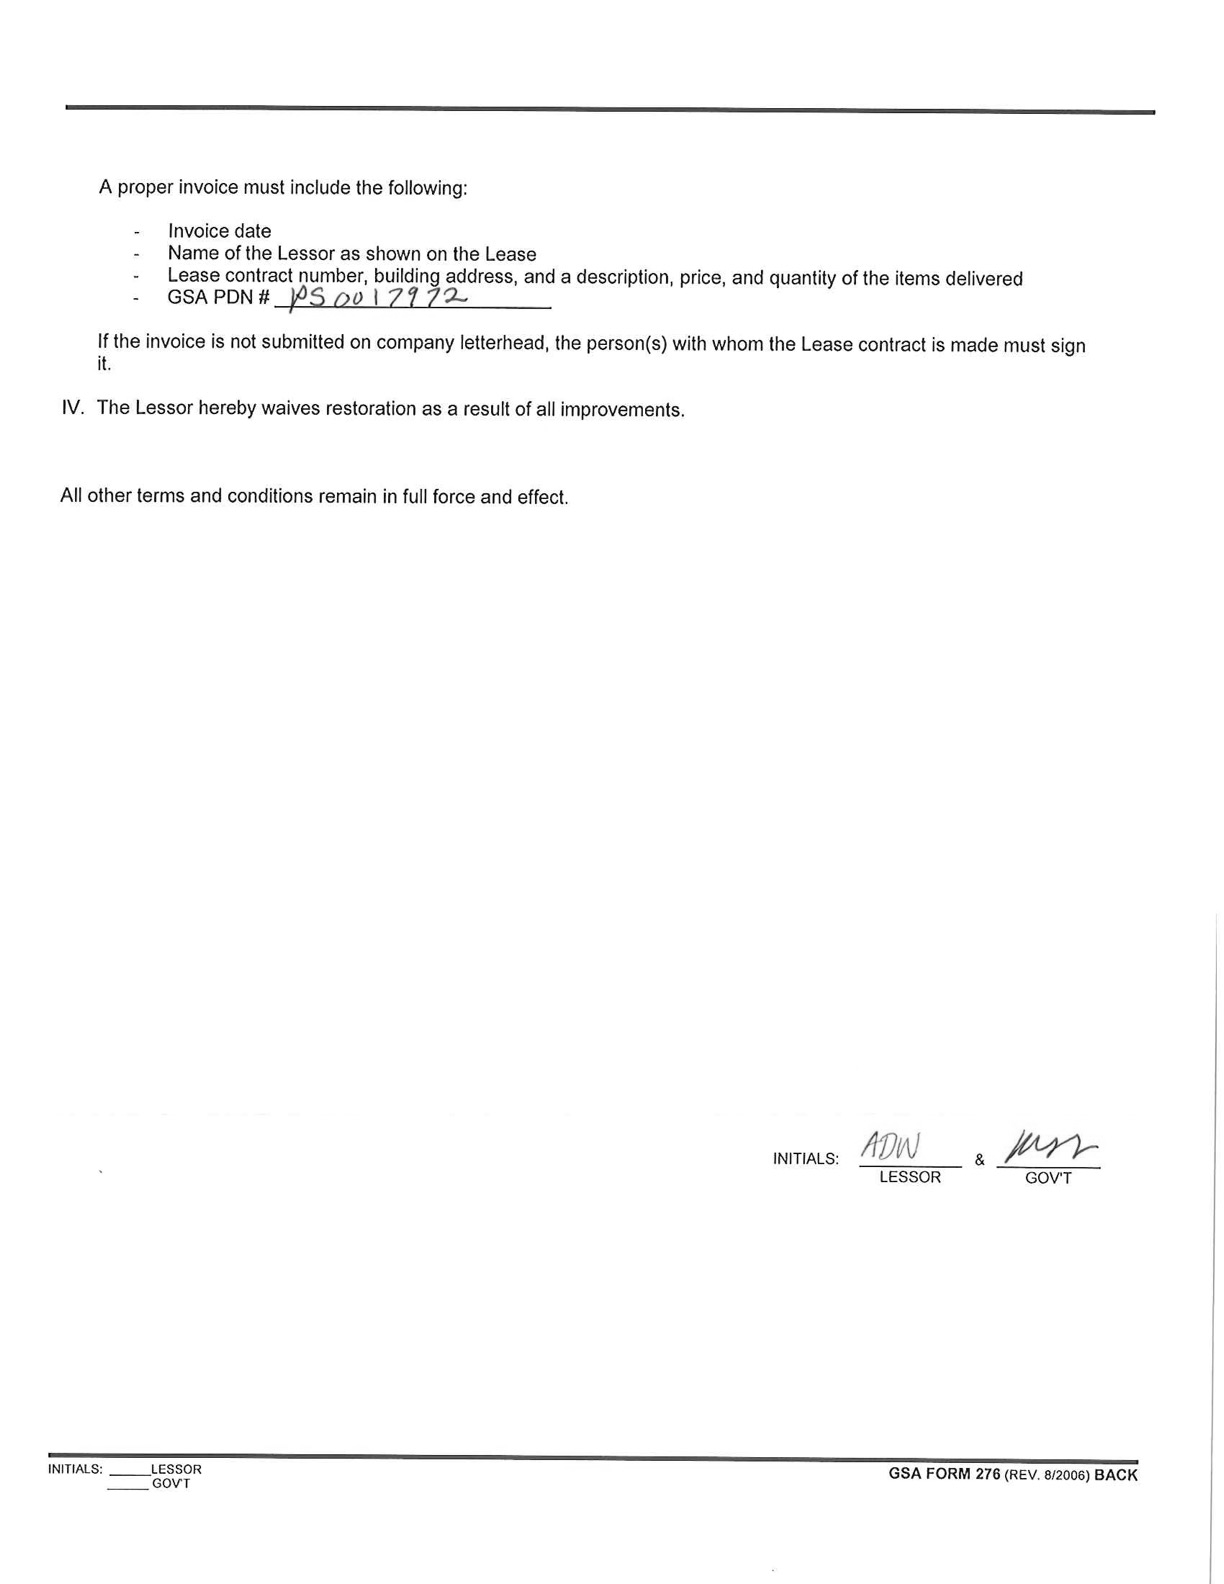

In [8]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

In [10]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_signature_detector_gsa0628", "en", "public/ocr/models")
signature_detector = ImageSignatureDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setOutputLabels(["1"]) \
    .setScoreThreshold(0.4)

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten_image")
splitter.setDropCols("image")
splitter.setImageType(10)

draw_regions = ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("region") \
   .setOutputCol("image_with_regions")

pipeline = PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    draw_regions,
    splitter
])

image_signature_detector_gsa0628 download started this may take some time.
Approximate size to download 243.9 MB


In [11]:
result =  pipeline.transform(image_df).cache()
result.printSchema()

root
 |-- handwritten_image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- region: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: integer (nullable = false)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- hei

In [12]:
result.select("handwritten_image.nChannels", "handwritten_image.height", "handwritten_image.width", "handwritten_image.mode", "handwritten_image.resolution").show(truncate=False)

+---------+------+-----+----+----------+
|nChannels|height|width|mode|resolution|
+---------+------+-----+----+----------+
|1        |38    |224  |10  |0         |
+---------+------+-----+----+----------+




    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/signature/LCT04596-SLA-3-2.jpg
    Resolution: 0 dpi
    Width: 1224 px
    Height: 1584 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


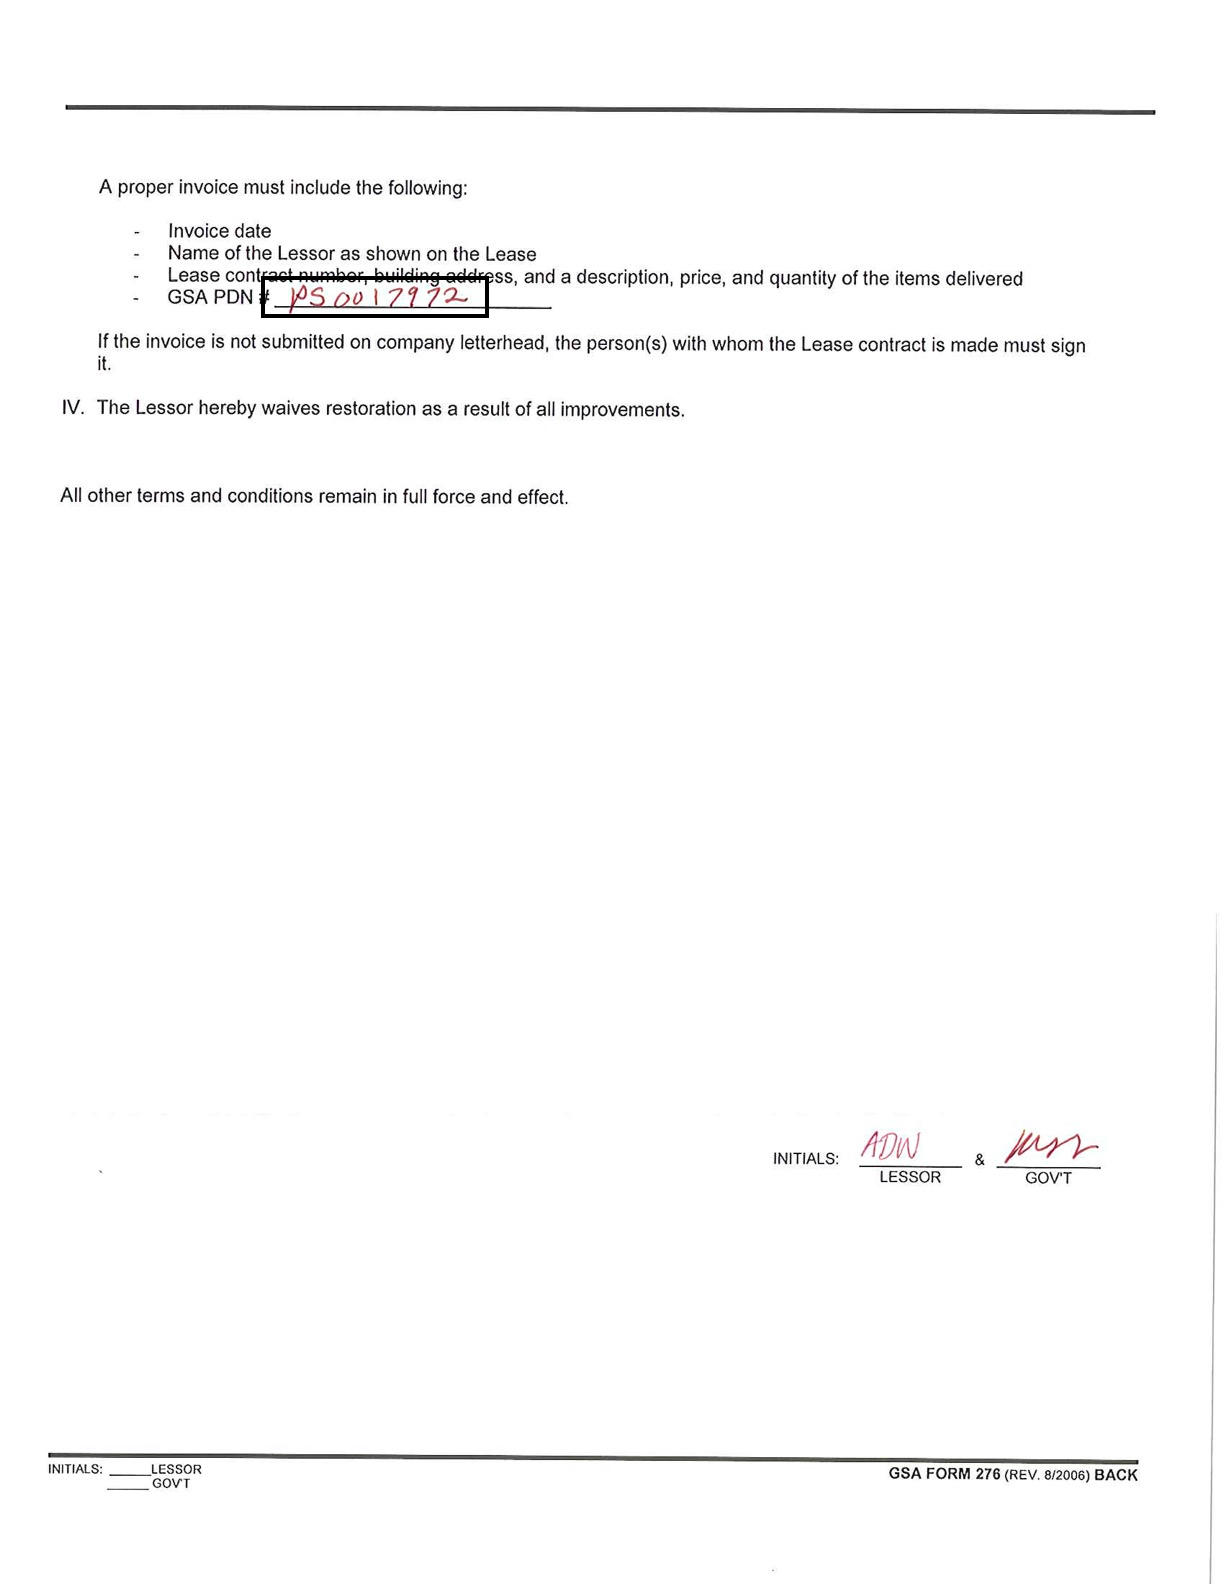

In [13]:
display_images(result, "image_with_regions")

In [14]:
pretrained_model = ("image_handwritten_text_recognition_IAM0724", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten_image") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

image_handwritten_text_recognition_IAM0724 download started this may take some time.
Approximate size to download 44.9 MB


In [15]:
result2.select("handwritten_text").show(truncate=False)

+--------------------+
|handwritten_text    |
+--------------------+
|Isjseilbeil'llicizyt|
+--------------------+



In [ ]:
## one more example

In [39]:
imagePath = "./data/handwritten/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg"

image_df = spark.read.format("binaryFile").load(imagePath)

In [40]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_signature_detector_gsa0628", "en", "public/ocr/models")
signature_detector = ImageSignatureDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setOutputLabels(["1"]) \
    .setScoreThreshold(0.4)

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten_image")
splitter.setDropCols("image")
splitter.setImageType(10)

draw_regions = ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("region") \
   .setOutputCol("image_with_regions")

pipeline = PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    draw_regions,
    splitter
])

image_signature_detector_gsa0628 download started this may take some time.
Approximate size to download 243.9 MB


In [41]:
result =  pipeline.transform(image_df).cache()
result.printSchema()

root
 |-- handwritten_image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- region: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: integer (nullable = false)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 | 

In [42]:
result.select("handwritten_image.nChannels", "handwritten_image.height", "handwritten_image.width", "handwritten_image.mode", "handwritten_image.resolution").show(truncate=False)

+---------+------+-----+----+----------+
|nChannels|height|width|mode|resolution|
+---------+------+-----+----+----------+
|1        |71    |392  |10  |0         |
|1        |71    |242  |10  |0         |
|1        |72    |827  |10  |0         |
|1        |62    |1253 |10  |0         |
+---------+------+-----+----+----------+




    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


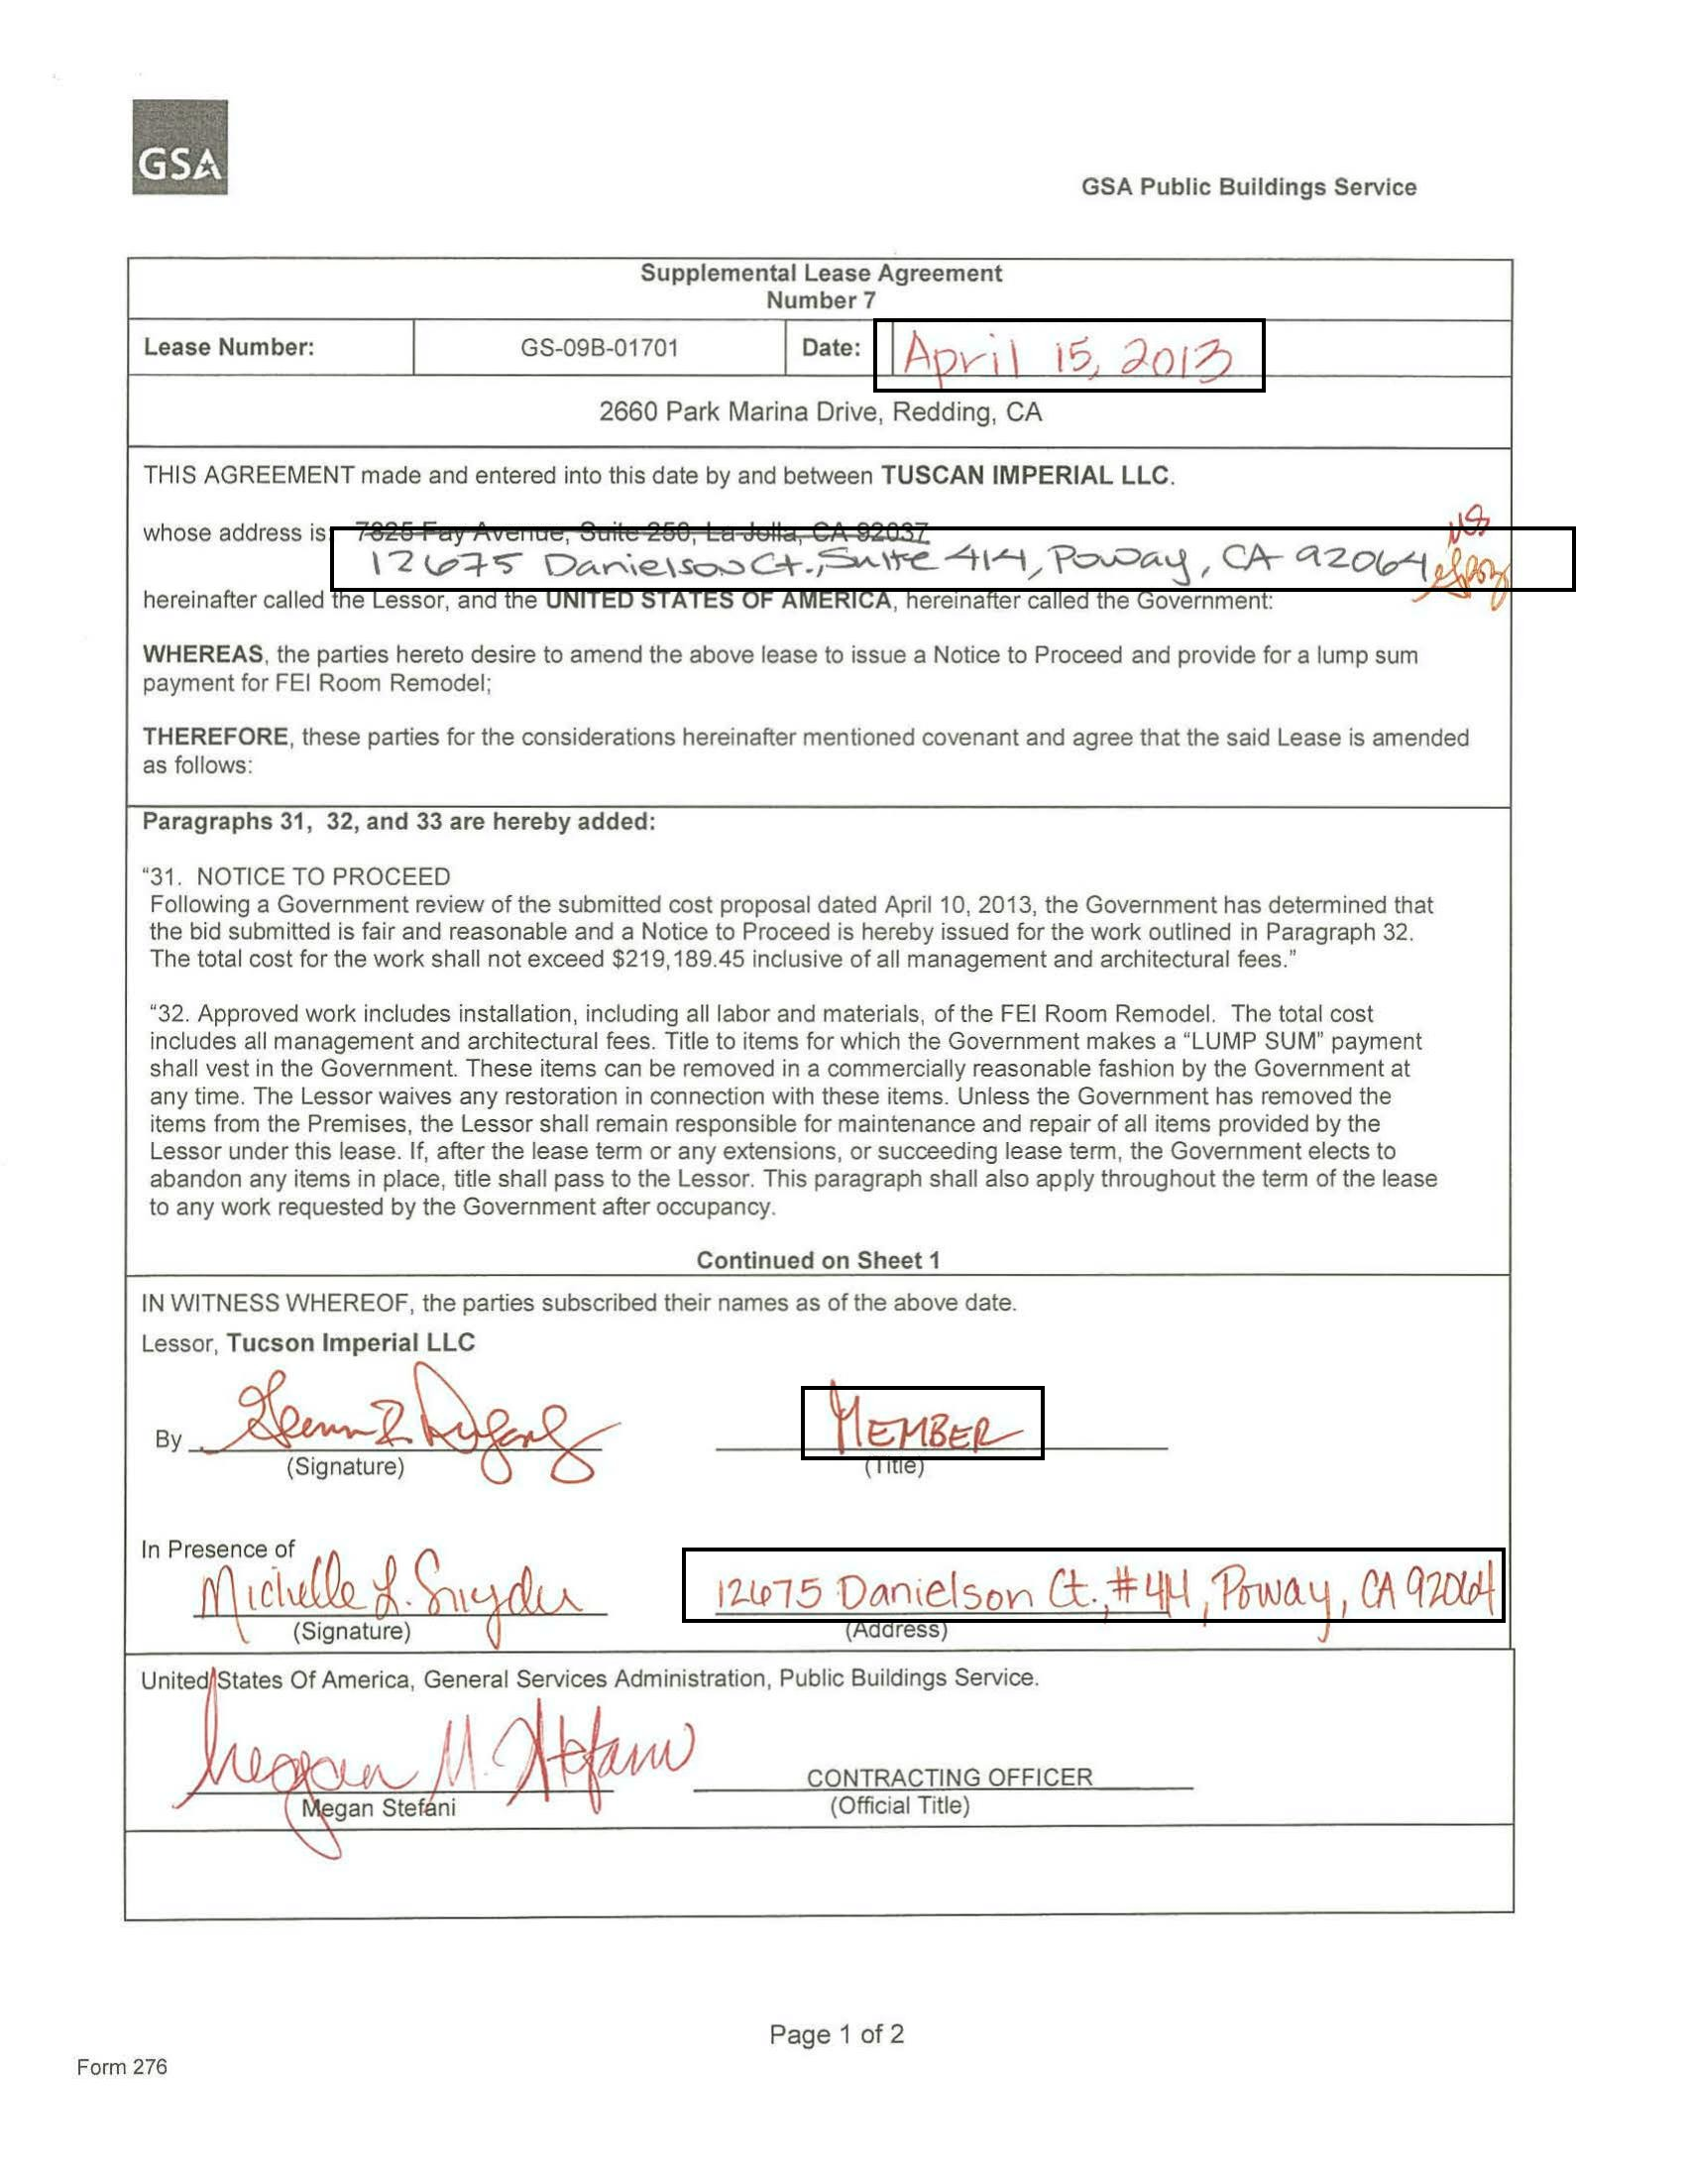


    Image #1:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


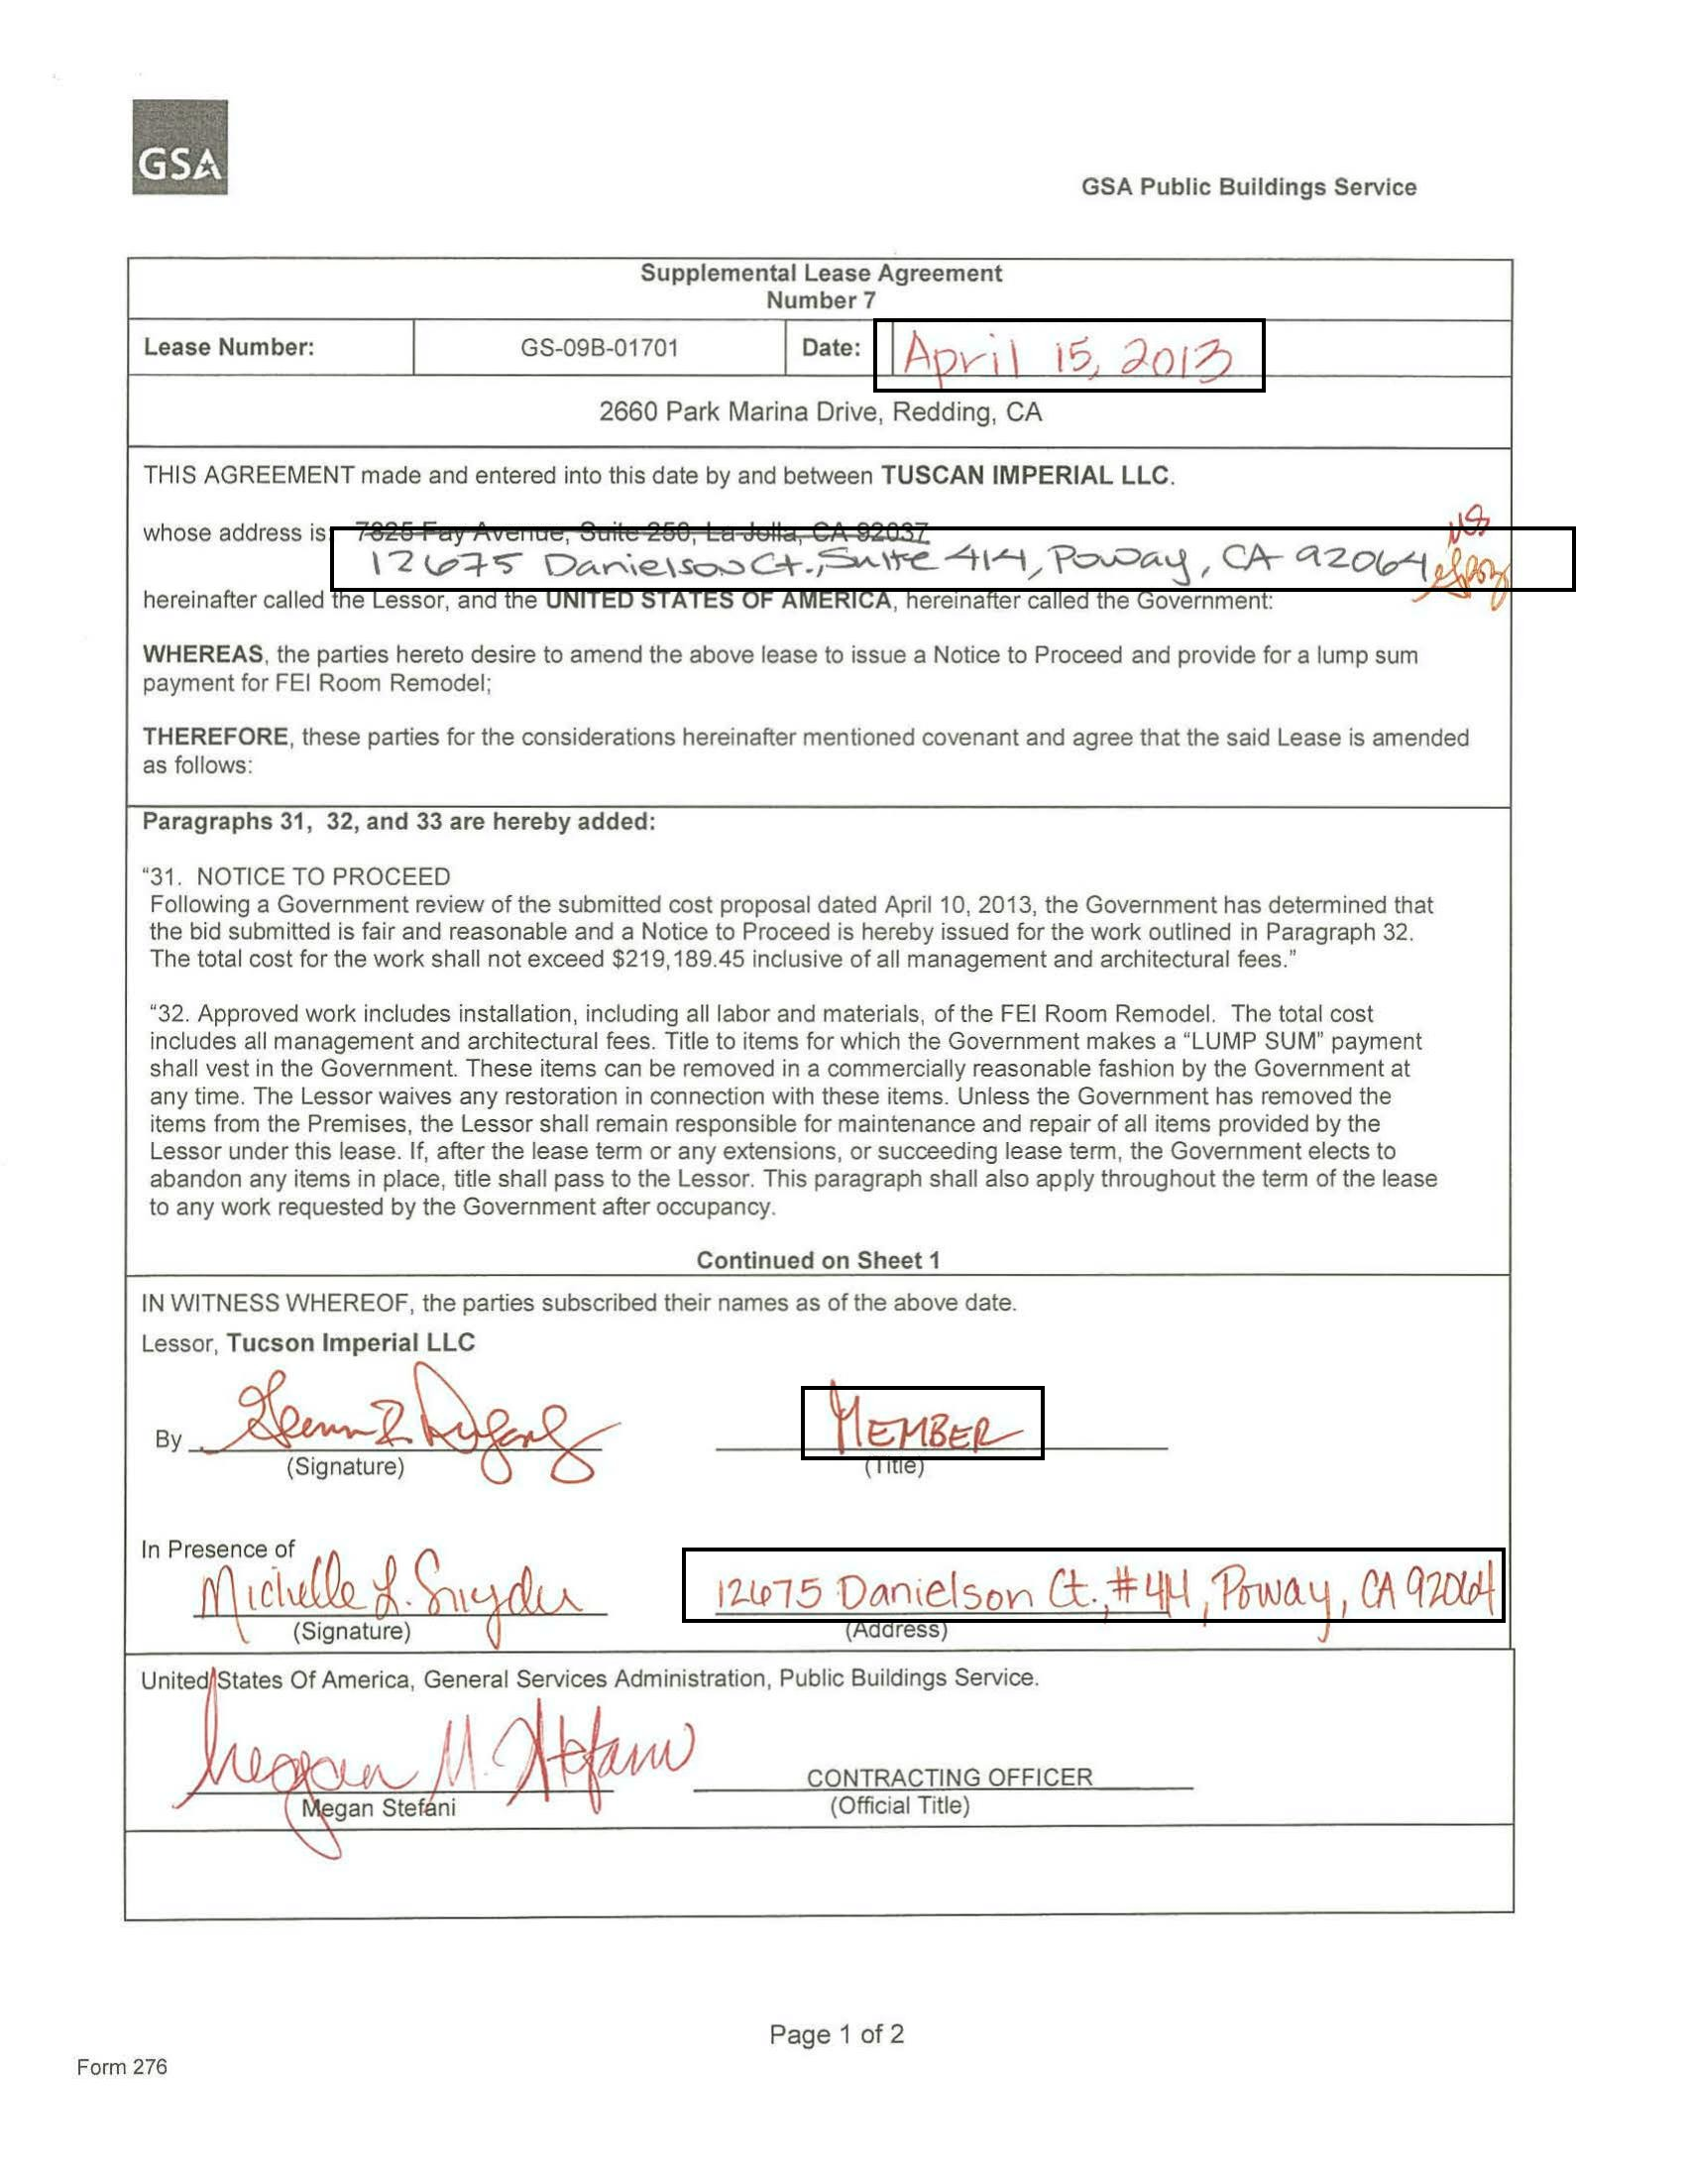


    Image #2:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


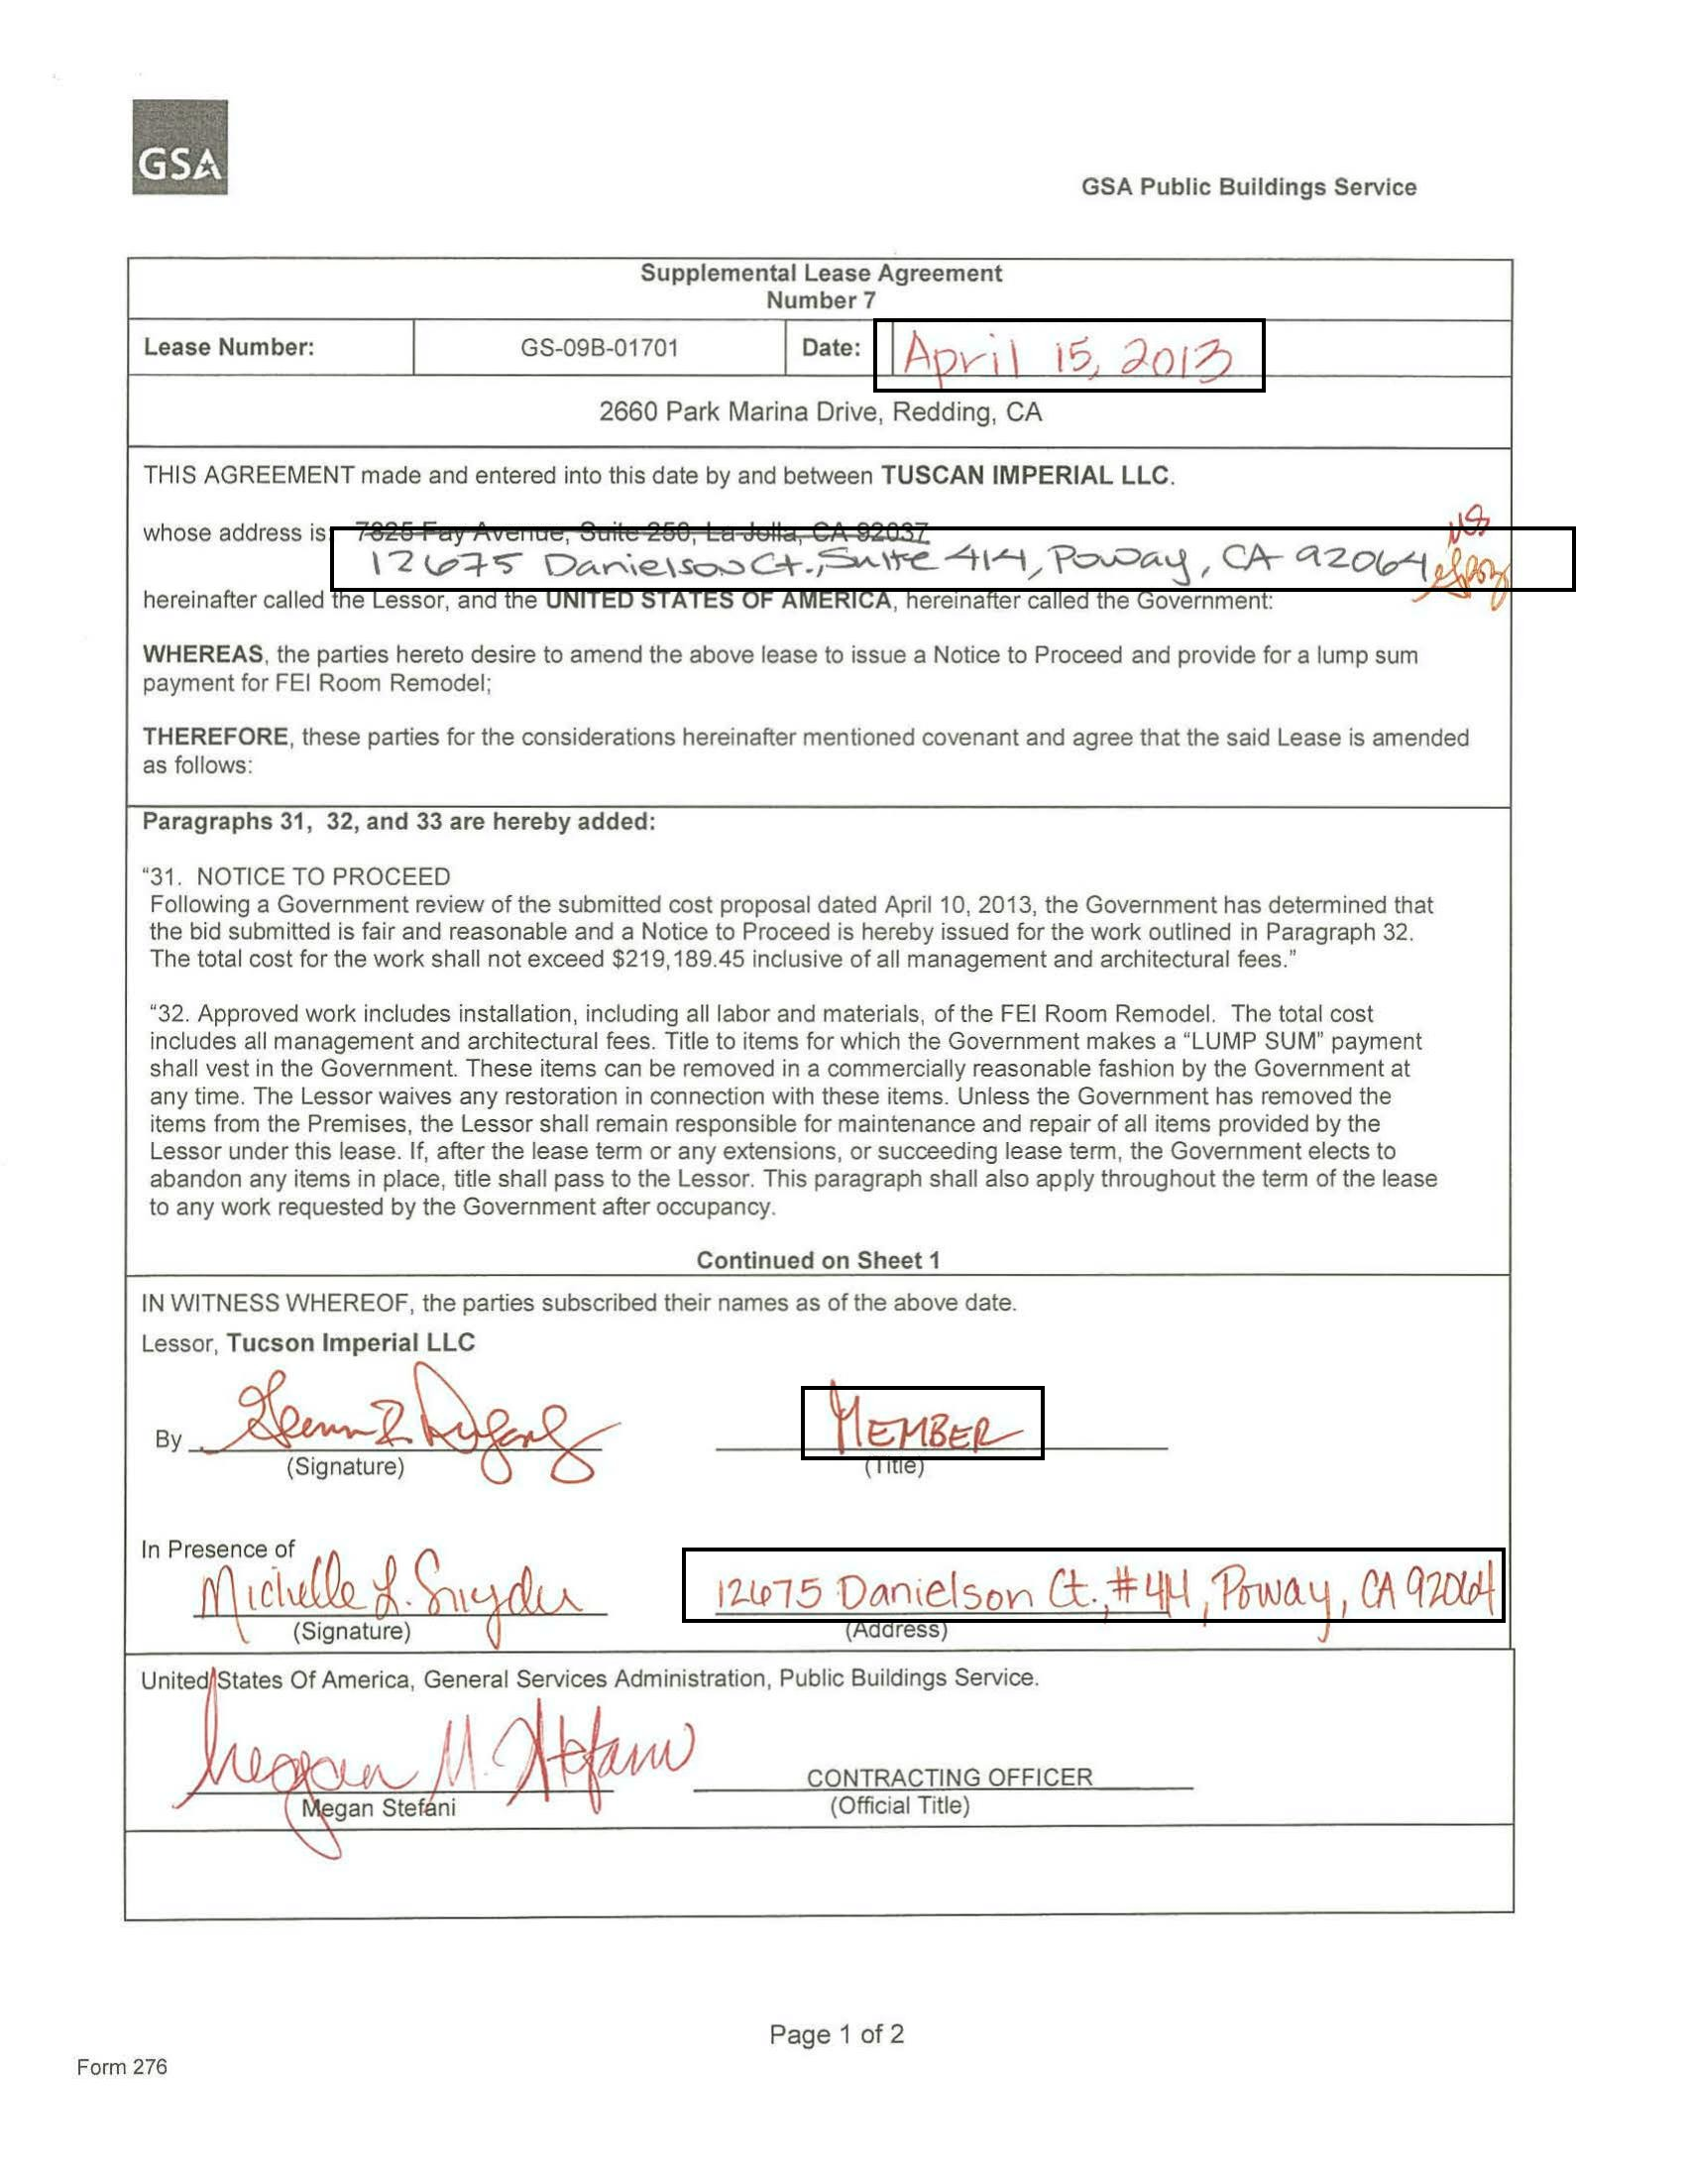


    Image #3:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


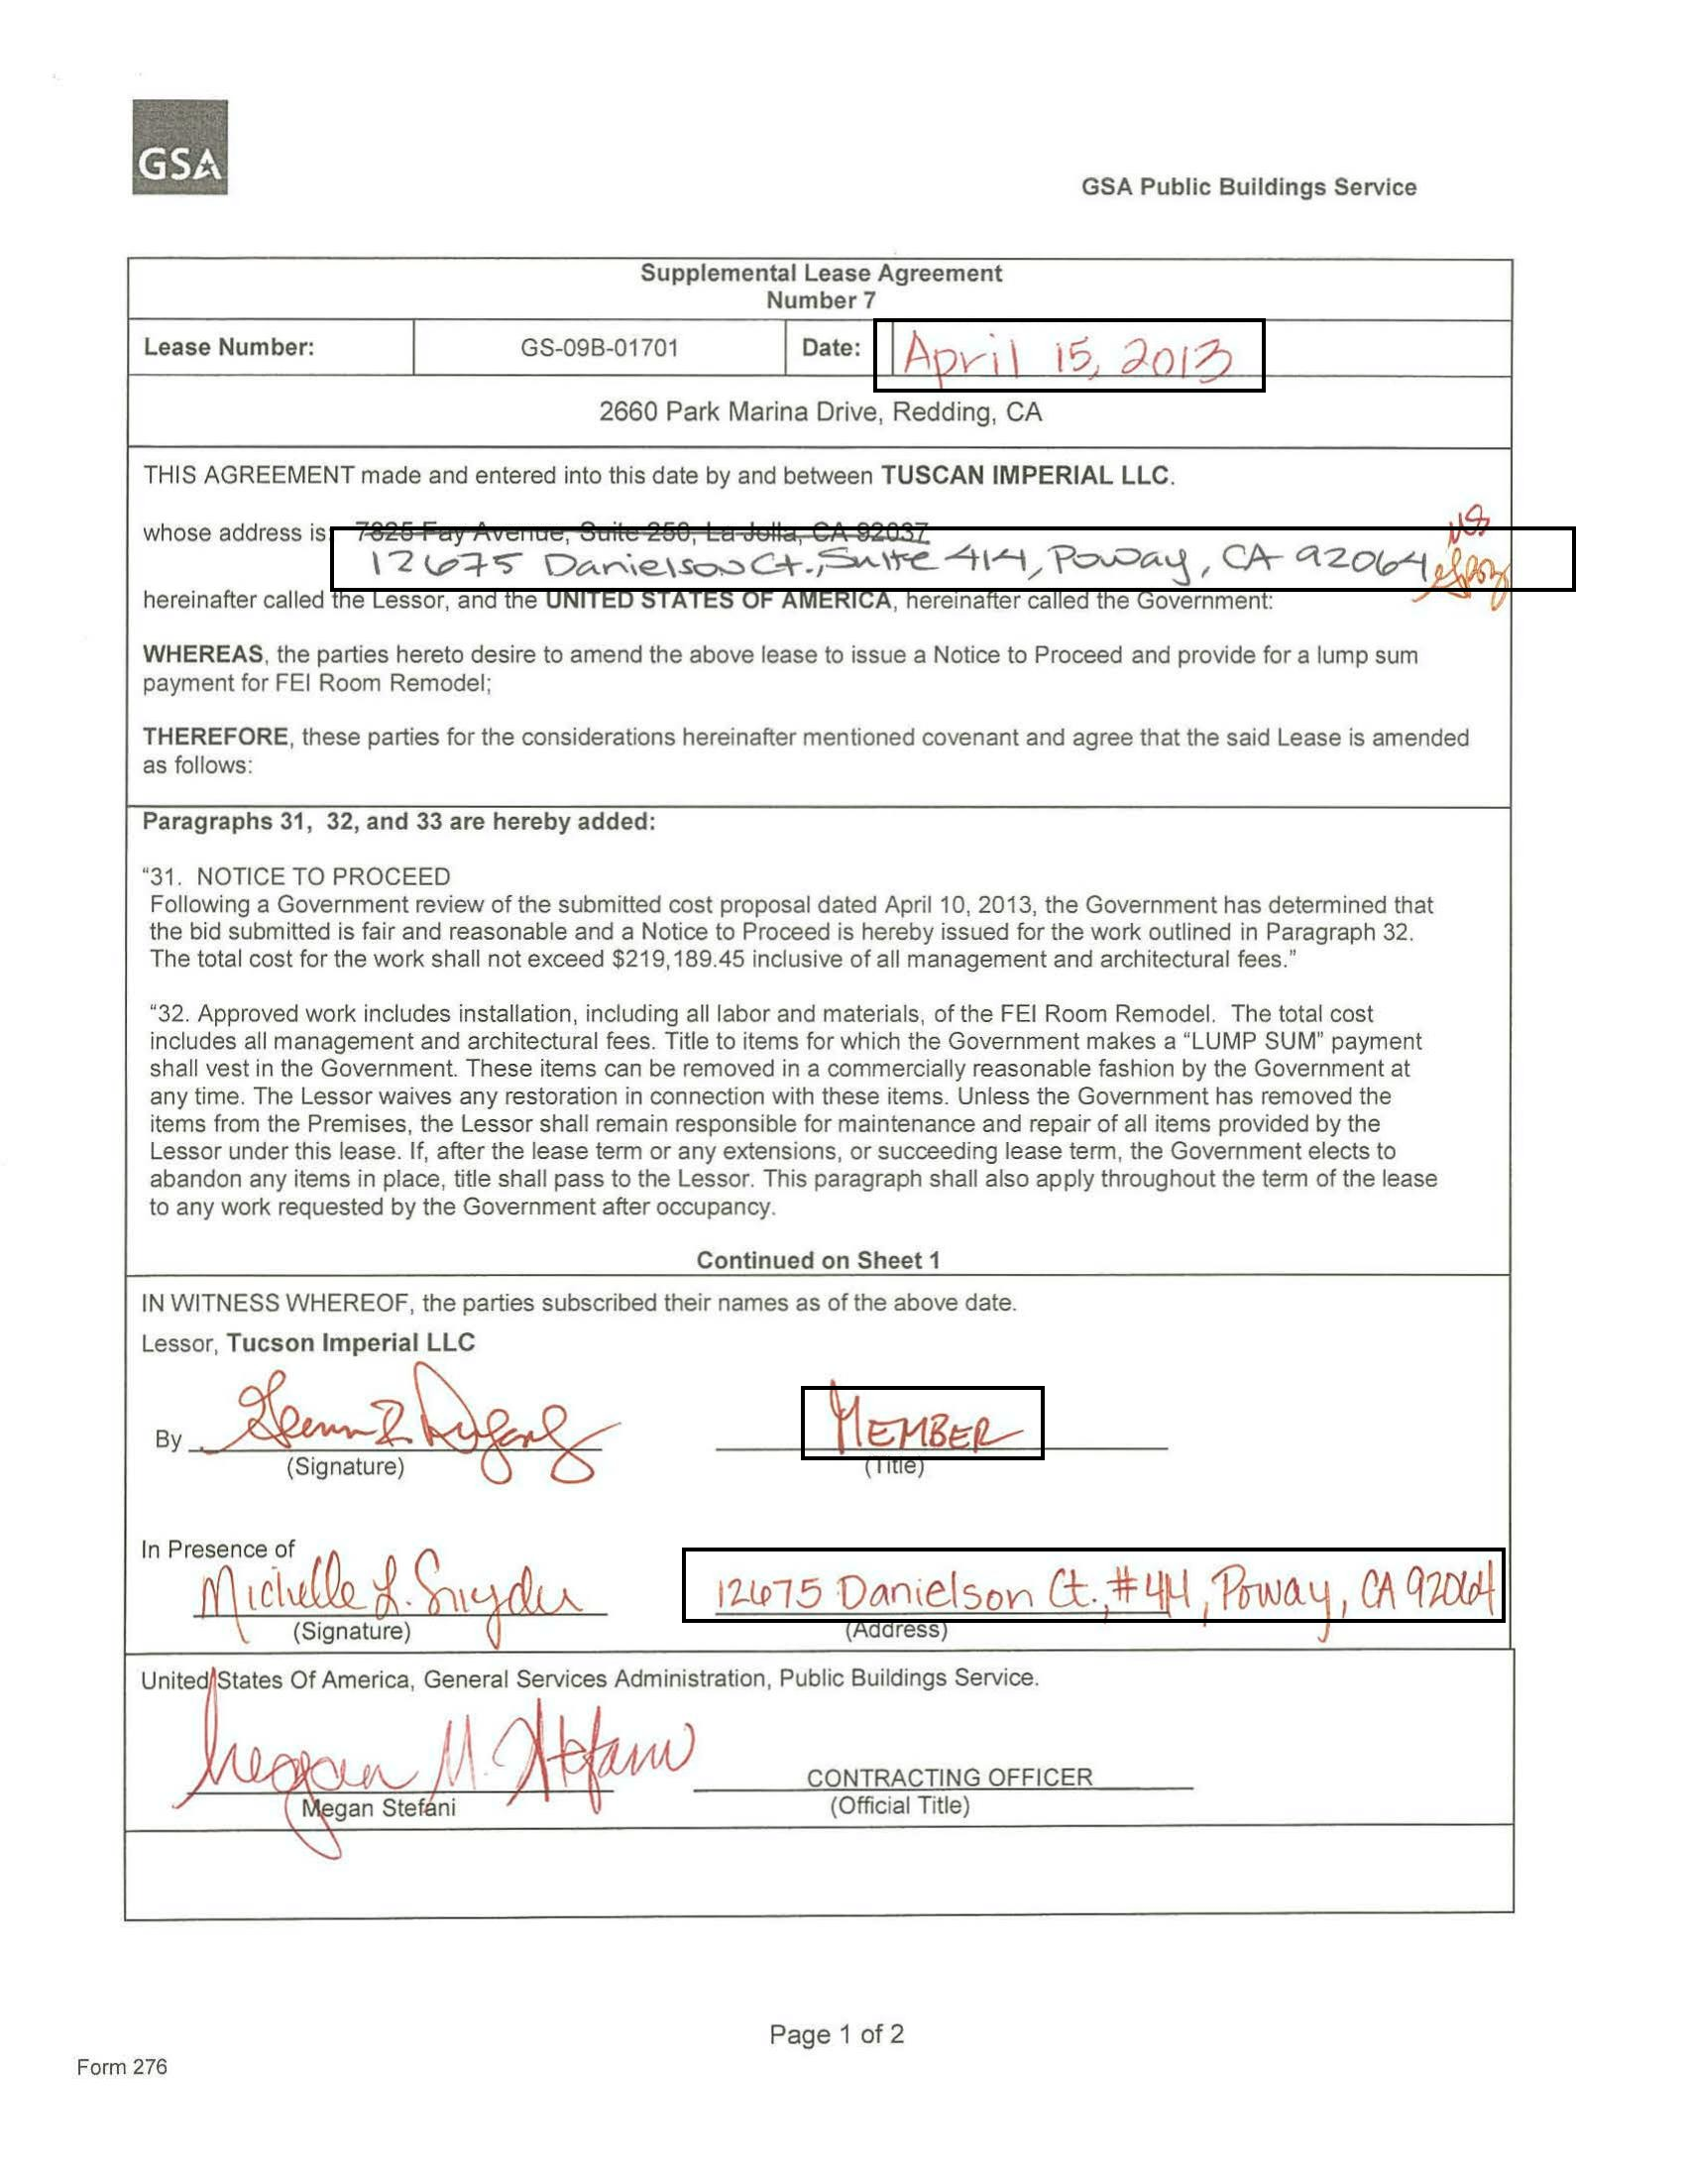

In [43]:
display_images(result, "image_with_regions")

In [44]:
pretrained_model = ("image_handwritten_text_recognition_IAM0724", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten_image") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

image_handwritten_text_recognition_IAM0724 download started this may take some time.
Approximate size to download 44.9 MB


In [45]:
result2.select("handwritten_text").show(truncate=False)

+------------------------------------------------------------+
|handwritten_text                                            |
+------------------------------------------------------------+
|IDriDusein                                                  |
|KfXBEf                                                      |
|RLesEvanielserEt #yM , Poway , AnArot                       |
|bf8RTDI8IgohasarhasesosorgIBsifzexM , Povay , AA azobrifinhl|
+------------------------------------------------------------+

